In [15]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = None


In [16]:
!pip install protobuf==3.20.3


In [17]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_fscore_support
)
from sklearn.model_selection import StratifiedKFold

#🔹 CELL 2 — Dataset Paths & Hyperparameters
train_dir = '/kaggle/input/skin-mal-ben-bcc-balanced/ISIC_BALANCED/train'
val_dir   = '/kaggle/input/skin-mal-ben-bcc-balanced/ISIC_BALANCED/val'
test_dir  = '/kaggle/input/skin-mal-ben-bcc-balanced/ISIC_BALANCED/test'

IMG_SIZE = (224, 224)   # REQUIRED for EfficientNet
BATCH_SIZE = 32
EPOCHS = 50
NUM_CLASSES = 3

#🔹 CELL 3 — Preprocessing & Data Generators (ONE CELL)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8,1.2]
)

val_datagen  = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

#🔹 CELL 4 — MODEL 1: EfficientNet FROZEN
base_model = EfficientNetB3(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

base_model.trainable = False  # 🔒 FROZEN

inputs = layers.Input(shape=(224,224,3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model_frozen = models.Model(inputs, outputs)

model_frozen.compile(
    optimizer=optimizers.Adam(1e-3),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

model_frozen.summary()

#🔹 CELL 5 — TRAIN Frozen Model
callbacks = [
    EarlyStopping(patience=8, restore_best_weights=True),
    ReduceLROnPlateau(patience=4, factor=0.3)
]

history_frozen = model_frozen.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)


Found 1852 images belonging to 3 classes.
Found 463 images belonging to 3 classes.
Found 1060 images belonging to 3 classes.
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 7, 7, 1536)     │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,183,922 (42.66 MB)

 Trainable params: 397,315 (1.52 MB)

 Non-trainable params: 10,786,607 (41.15 MB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1765979626.905104     191 service.cc:152] XLA service 0x79b07c27d110 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765979626.905149     191 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1765979626.905156     191 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1765979630.411993     191 cuda_dnn.cc:529] Loaded cuDNN version 91002
2025-12-17 13:53:59.568368: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-17 13:53:59.715428: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-17 13:54:00.092069: E external/local_xl

56/58 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step - accuracy: 0.3548 - loss: 1.7747

2025-12-17 13:54:57.885877: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-17 13:54:58.031541: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-17 13:54:58.407505: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-17 13:54:58.554131: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-17 13:54:59.271968: E external/local_xla/xla/stream_

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3548 - loss: 1.7738  

2025-12-17 13:55:34.935990: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-17 13:55:35.079172: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-17 13:55:35.416222: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-17 13:55:35.563057: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-17 13:55:36.285100: E external/local_xla/xla/stream_

58/58 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.3548 - loss: 1.7734 - val_accuracy: 0.3132 - val_loss: 1.1334 - learning_rate: 0.0010
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 30s 517ms/step - accuracy: 0.3569 - loss: 1.5592 - val_accuracy: 0.4190 - val_loss: 1.0988 - learning_rate: 0.0010
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 30s 509ms/step - accuracy: 0.3625 - loss: 1.3981 - val_accuracy: 0.3585 - val_loss: 1.0970 - learning_rate: 0.0010
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 29s 505ms/step - accuracy: 0.3606 - loss: 1.3294 - val_accuracy: 0.3607 - val_loss: 1.0933 - learning_rate: 0.0010
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 29s 509ms/step - accuracy: 0.3927 - loss: 1.2133 - val_accuracy: 0.4017 - val_loss: 1.0908 - learning_rate: 0.0010
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 29s 505ms/step - accuracy: 0.3994 - loss: 1.1738 - val_accuracy: 0.3132 - val_loss: 1.0934 - learning_rate: 0.0010
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 29s 506ms/step - accuracy: 0.3775 - loss: 1.1947 - val_ac

##🔹 CELL 6 — MODEL 2: EfficientNet FINE-TUNED

In [18]:
base_model.trainable = True

for layer in base_model.layers[:-30]:
    layer.trainable = False

model_finetuned = models.clone_model(model_frozen)
model_finetuned.set_weights(model_frozen.get_weights())

model_finetuned.compile(
    optimizer=optimizers.Adam(1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

model_finetuned.summary()
#🔹 CELL 7 — TRAIN Fine-Tuned Model
history_finetuned = model_finetuned.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ keras_tensor_408 (InputLayer)   │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 7, 7, 1536)     │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,183,922 (42.66 MB)

 Trainable params: 3,951,485 (15.07 MB)

 Non-trainable params: 7,232,437 (27.59 MB)

Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.3633 - loss: 1.1736 - val_accuracy: 0.3305 - val_loss: 1.6901 - learning_rate: 1.0000e-04
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 29s 499ms/step - accuracy: 0.3518 - loss: 1.1517 - val_accuracy: 0.3305 - val_loss: 1.4119 - learning_rate: 1.0000e-04
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 30s 512ms/step - accuracy: 0.3062 - loss: 1.1544 - val_accuracy: 0.3305 - val_loss: 1.1548 - learning_rate: 1.0000e-04
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 29s 503ms/step - accuracy: 0.3481 - loss: 1.1337 - val_accuracy: 0.3348 - val_loss: 1.0981 - learning_rate: 1.0000e-04
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 29s 501ms/step - accuracy: 0.3400 - loss: 1.1364 - val_accuracy: 0.3564 - val_loss: 1.0963 - learning_rate: 1.0000e-04
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 29s 499ms/step - accuracy: 0.3461 - loss: 1.1165 - val_accuracy: 0.3434 - val_loss: 1.0958 - learning_rate: 1.0000e-04
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 29s 499ms/step - accur

🔹 CELL 8 — Evaluation Function (Percent Format)

In [19]:
def evaluate_model(model, test_gen):
    y_true = test_gen.classes
    y_prob = model.predict(test_gen)
    y_pred = np.argmax(y_prob, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted'
    )

    acc = np.mean(y_true == y_pred)
    auc = roc_auc_score(tf.keras.utils.to_categorical(y_true, NUM_CLASSES), y_prob)

    print(f"Accuracy  : {acc*100:.2f}%")
    print(f"Precision : {precision*100:.2f}%")
    print(f"Recall    : {recall*100:.2f}%")
    print(f"F1-Score  : {f1*100:.2f}%")
    print(f"AUC-ROC   : {auc*100:.2f}%")

    print("\nClassification Report:")
    print(classification_report(
        y_true,
        y_pred,
        target_names=list(test_gen.class_indices.keys()),
        digits=4
    ))

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_gen.class_indices.keys(),
                yticklabels=test_gen.class_indices.keys())
    plt.title("Confusion Matrix")
    plt.show()


🔹 CELL 9 — Evaluate Frozen Model

33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step

2025-12-17 14:30:41.128093: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-17 14:30:41.265249: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-17 14:30:41.576958: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-17 14:30:41.723696: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-17 14:30:42.410957: E external/local_xla/xla/stream_

34/34 ━━━━━━━━━━━━━━━━━━━━ 37s 789ms/step
Accuracy  : 40.19%
Precision : 54.59%
Recall    : 40.19%
F1-Score  : 30.32%
AUC-ROC   : 72.69%

Classification Report:
              precision    recall  f1-score   support

         BCC     0.7500    0.0150    0.0294       400
      benign     0.3807    0.8861    0.5326       360
   malignant     0.4720    0.3367    0.3930       300

    accuracy                         0.4019      1060
   macro avg     0.5342    0.4126    0.3183      1060
weighted avg     0.5459    0.4019    0.3032      1060



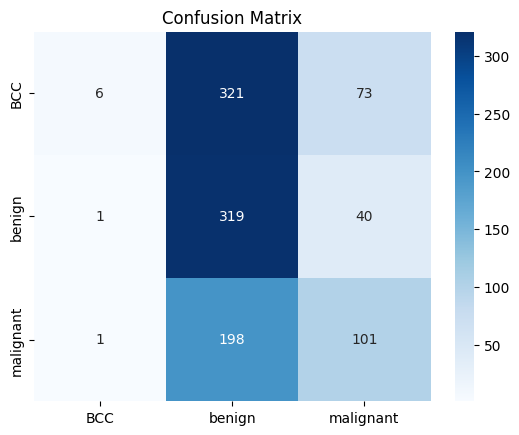

In [20]:
evaluate_model(model_frozen, test_gen)


🔹 CELL 10 — Evaluate Fine-Tuned Model

34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 424ms/step
Accuracy  : 46.13%
Precision : 39.73%
Recall    : 46.13%
F1-Score  : 37.66%
AUC-ROC   : 75.73%

Classification Report:
              precision    recall  f1-score   support

         BCC     0.0000    0.0000    0.0000       400
      benign     0.8821    0.5611    0.6859       360
   malignant     0.3454    0.9567    0.5075       300

    accuracy                         0.4613      1060
   macro avg     0.4092    0.5059    0.3978      1060
weighted avg     0.3973    0.4613    0.3766      1060



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

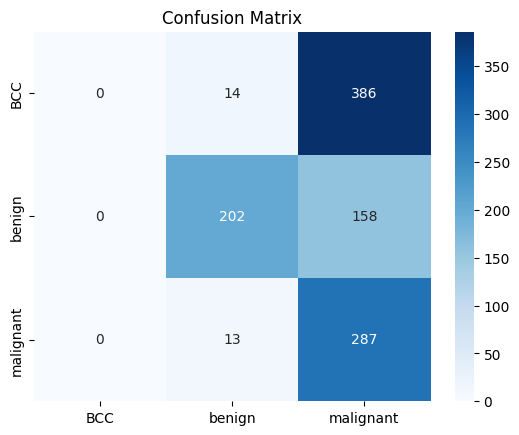

In [21]:
evaluate_model(model_finetuned, test_gen)


🔹 CELL 11 — Stratified K-Fold (30 & 50)

In [23]:
def stratified_kfold_auc(model_fn, X, y, folds=30):
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
    aucs = []

    for train_idx, val_idx in skf.split(X, y):
        model = model_fn()
        model.fit(X[train_idx], y[train_idx], epochs=5, verbose=0)
        preds = model.predict(X[val_idx])
        aucs.append(
            roc_auc_score(
                tf.keras.utils.to_categorical(y[val_idx], NUM_CLASSES),
                preds
            )
        )
    print(f"Mean AUC ({folds}-Fold): {
    np.mean(aucs)*100:.2f}%")
